# Robot trading

## 1. Preparando el ambiente

### Descargando bibliotecas

In [8]:
pip install pandas --upgrade

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install Beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


### Importando bibliotecas

In [633]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from bs4 import BeautifulSoup as bs
import requests
import datetime as dt


### Revisando versiones

In [615]:
print(f'La version de Pandas es la V {pd.__version__}')
print(f'La version de Numpy es la V {np.__version__}')

La version de Pandas es la V 2.1.4
La version de Numpy es la V 1.26.2


## 2. Obteniendo los datos

In [616]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_nuevo

In [617]:
# Se obtiene el historico de 7 días del precio del Bitcoin
def importar_base_bitcoin():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_nuevo
    bitcoin = yf.Ticker('BTC-USD').history(period = '7d', interval = '5m')
    df_bitcoin = pd.DataFrame(bitcoin)
    return df_bitcoin


In [665]:
# Se obtiene el precio actual del bitcoin, asi como su tendencia
def extraer_tendencias():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_nuevo, hora
    headers = {'User-agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36 Edg/120.0.0.0'}
    url = 'https://coinmarketcap.com/'
    respuesta = requests.get(url, headers)
    s = bs(respuesta.content, features = 'lxml')
    crypto_moneda = s.find('p', {'class' : 'sc-4984dd93-0 kKpPOn'}).getText().strip()
    precio_actual = float(s.find('div', {'class' : ['sc-a0353bbc-0 gDrtaY', 'sc-a0353bbc-0 gDrtaY rise', 'sc-a0353bbc-0 gDrtaY fall']}).getText().strip().replace('$', '').replace(',',''))
    ultima_hora = s.findAll('span', {'class' : 'sc-d55c02b-0'},limit=1)
    porcentaje_ultima_hora = ultima_hora[0].getText()
    hora= dt.datetime.now().strftime('%d/%m/%y, a las %H:%M')
    for clases in ultima_hora:
        clase = clases['class']
    if 'iwhBxy' in clase:
      tendencia = 'alcista'
    elif 'gUnzUB' in clase:
      tendencia = 'bajista'
    print(f'El precio actual del {crypto_moneda}, hoy {hora} es de ${precio_actual} USD y su tendencia es {tendencia} del {porcentaje_ultima_hora}')

In [666]:
extraer_tendencias()

El precio actual del Bitcoin, hoy 18/12/23, a las 02:06 es de $41318.15 USD y su tendencia es bajista del 0.15%


## 3. Limpiando los datos

In [621]:
# Se crea una copia de los datos antes de manipularlos
global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_nuevo, Q1
df_bitcoin_limpio = df_bitcoin.copy()
df_bitcoin_limpio.drop(['Open', 'High', 'Low', 'Dividends', 'Stock Splits'], axis= 1, inplace= True)
df_bitcoin_limpio


,Close,Volume
Datetime,,
2023-12-12 00:00:00+00:00,41263.531250,0
2023-12-12 00:05:00+00:00,41193.867188,41369600
2023-12-12 00:10:00+00:00,41188.453125,43462656
2023-12-12 00:15:00+00:00,41364.339844,63012864
2023-12-12 00:20:00+00:00,41493.078125,108335104
...,...,...
2023-12-18 00:00:00+00:00,41379.726562,46403584
2023-12-18 00:05:00+00:00,41268.421875,53404672
2023-12-18 00:10:00+00:00,41203.277344,58112000


In [622]:
def limpieza_datos():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_nuevo, li
    df_bitcoin_limpio.index.duplicated(keep='first')
    df_bitcoin_limpio.dropna(subset= ['Close'], inplace= True)
    df_bitcoin_limpio.drop(df_bitcoin_limpio[(df_bitcoin_limpio['Volume'] == 0)].index, inplace=True)
    cierre = df_bitcoin_limpio['Close']
    Q1 = cierre.quantile(.25)
    Q3 = cierre.quantile(.75)
    IIQ = Q3 - Q1
    li = Q1 - 1.5 * IIQ
    ls = Q3 + 1.5 * IIQ 
    seleccion = ((cierre >= Q1) & (cierre <= Q3))
    df_nuevo = df_bitcoin_limpio[seleccion]
    media_bitcoin = df_nuevo['Close'].mean().round(2)
    return media_bitcoin

In [623]:
limpieza_datos()


42152.65

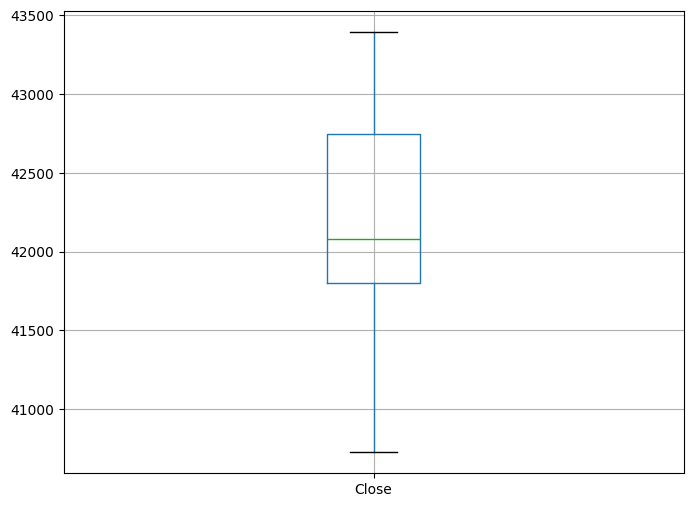

In [624]:
plt.rc('figure', figsize=(8,6))
df_bitcoin_limpio.boxplot(['Close'])
plt.show()

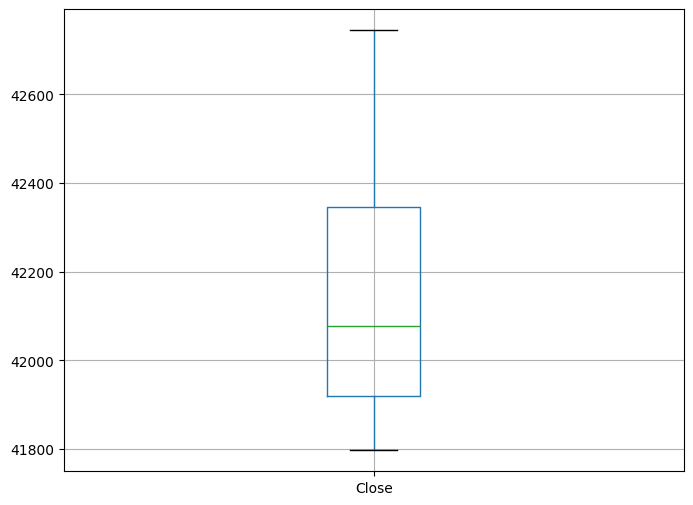

In [625]:
df_nuevo.boxplot(['Close'])
plt.show()


## 4. Tomando decisiones

In [627]:
def tomar_decisiones():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_nuevo
    algoritmo_decision = ''
    if ((precio_actual >= media_bitcoin) & (tendencia == 'bajista')):
        algoritmo_decision = 'Vender'
    elif ((precio_actual < media_bitcoin) & (tendencia == 'alcista')):
        algoritmo_decision = 'Comprar'
    else:
        algoritmo_decision = 'Esperar'
    return algoritmo_decision

In [628]:
extraer_tendencias()
tomar_decisiones()

El precio actual del Bitcoin es de $41240.99 USD y su tendencia es bajista del 0.85%


'Esperar'

In [679]:
media_bitcoin

42152.65

## 5. Visualización

In [690]:
def visualizacion():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_nuevo
    df_bitcoin['Promedio'] = media_bitcoin
    plt.rc('figure', figsize = (16 , 5))
    plt.title('Precio historico de bitcoin (toma de decisión)', fontsize= 18, weight='bold')
    plt.ylabel('Precio - BTC', fontsize= 12, style='italic')
    plt.xlabel('Fecha', fontsize= 12, style='italic')
    plt.plot(df_bitcoin.index, df_bitcoin['Close'], label = (f'Valor al cierre: {df_bitcoin['Close'].iloc[-1].round(2):,} USD'), color='green')
    plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], label= (f"Valor promedio: {media_bitcoin:,} USD"), color='red')    
    plt.legend(loc='upper left', )
    plt.annotate( 
        f'{tomar_decisiones()}',
        fontsize=16, 
        xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]),
        xytext=(df_bitcoin.index[int(df_bitcoin.shape[0]/2 * 0.8)], int(media_bitcoin) *.97),        
        verticalalignment= 'center',
        horizontalalignment= 'left',
        arrowprops=dict(color='black', arrowstyle='-|>', connectionstyle='angle, angleA=0, angleB=90', 
                        linewidth=5, relpos=(1,0.5), capstyle='round', joinstyle='miter', shrinkA=8, shrinkB=10), 
        bbox=dict(boxstyle='round, pad=0.4', edgecolor='black', linewidth=3, facecolor='lightGray')
        )
    plt.grid(linewidth=0.5, alpha=0.8)
    plt.show()

El precio actual del Bitcoin, hoy 18/12/23, a las 02:28 es de $41293.88 USD y su tendencia es bajista del 0.04%


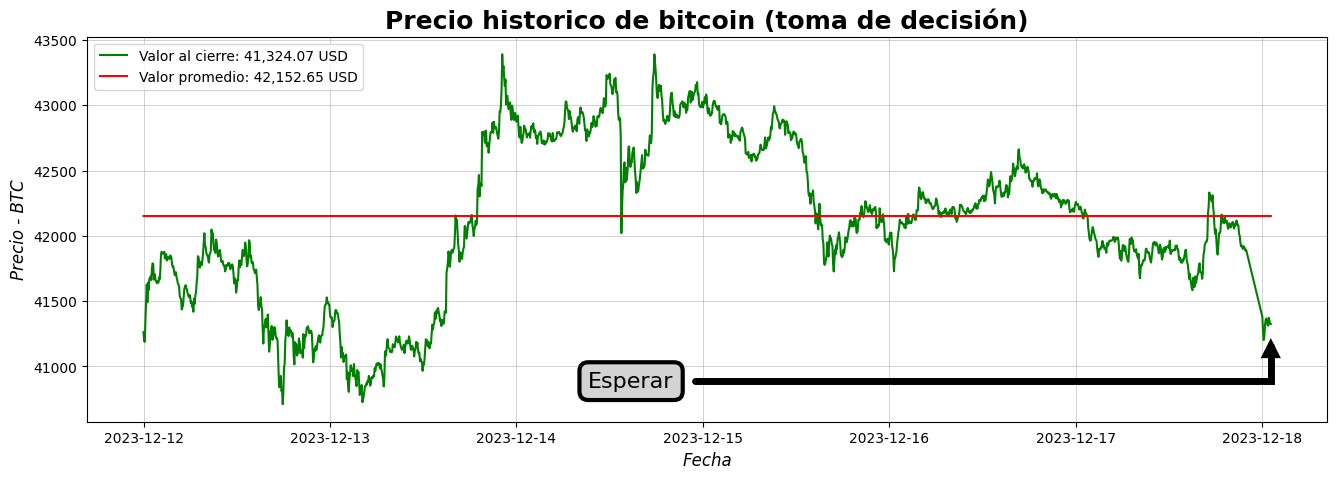

In [691]:
extraer_tendencias()
visualizacion()

## 6. Automatización

El precio actual del Bitcoin, hoy 18/12/23, a las 02:31 es de $41293.88 USD y su tendencia es bajista del 0.04%


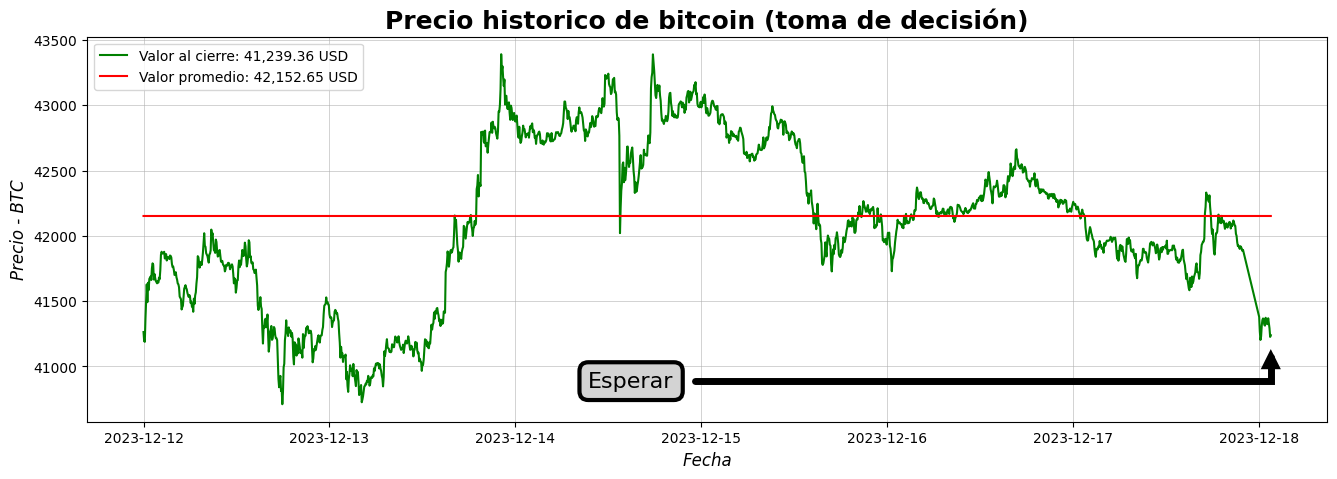

KeyboardInterrupt: 

In [692]:
from IPython.display import clear_output
import time

while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)